# Aim

Use the Python `autograd` package to carry out automatic differentiation of transit parameters, and replicate the results of Price and Rogers (2014) without any of the pain. [https://arxiv.org/pdf/1408.4124.pdf]

In [23]:
import autograd.numpy as np
from autograd import grad
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
# a very simple transit model with fixed numbers
# transit is piecewise linear

def simple_transit(t):
    times = np.array([0, 0.1, 0.3, 0.7, 0.9, 1], dtype=np.float64)
    fluxes = np.array([1, 1, 0.9, 0.9, 1, 1], dtype=np.float64)
    return interp1d(times, fluxes)(t)
       
def smooth_select(discontinuities, function_pieces):
    '''
    Takes in the inputs to np.select, and returns a smooth callable function that interpolates between them.
    Assumes the function is piecewise continuous, but not differentiable everywhere.
    Has limited scope: only use when ReLU is a good model (i.e. one side is a constant.)
    Fortunately, that's the case for a transit!
    '''
    interpolator = lambda x: np.log(1 + np.exp(x))
    if len(discontinuities) != len(function_pieces) - 1:
        raise AttributeError("Lengths of inputs do not match: make sure there is one more function piece than there are discontinuities.")
    if len(discontinuities) == 0:
        return function_pieces[0]
    d = discontinuities[0]
    left, right = function_pieces[0], function_pieces[1]
    assert np.isclose(left(d), right(d)) 
    
def transit(t, tc, delta, tau, T, f0, I):
    td = abs(t - tc)
    condlist = [
        td <= (T - tau - I) / 2,
        (T - tau - I) / 2 < td and td < T / 2 - abs(tau - I) / 2,
        T / 2 - abs(tau - I) / 2 < td and td < T / 2 + abs(tau + I) / 2,
        T / 2 + abs(tau - I) / 2 <= td and td < (T + tau + I) / 2,
        td >= (T + tau + I) / 2
    ]
    choicelist = [
        f0 - delta, 
        f0 - delta - (delta / (2 * tau * I)) * (td + (I - T + tau)/2) ** 2,
        f0 - delta + (delta / max(tau, I)) * (td + (-T + max(tau, I))/2),
        f0 - (delta / (2 * tau * I)) * ((T + tau + I) / 2 - td) ** 2,
        f0
    ]
    return np.select(condlist, choicelist)

ValueError: setting an array element with a sequence.

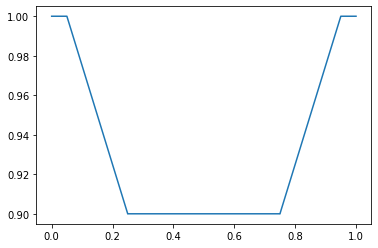

In [42]:
transit = get_transit(0.5, 0.1, 0.2, 0.7, 1, 0.001)
times = np.linspace(0, 1, 1001)
plt.plot(times, transit(times))
plt.plot(times, grad(transit)(times))

In [46]:
grad(transit)(np.array([3., 4.]))

TypeError: Grad only applies to real scalar-output functions. Try jacobian, elementwise_grad or holomorphic_grad.